In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp

from qubic.lib.MapMaking.Qatmosphere_2d import AtmosphereMaps

import yaml

import qubic
from qubic.lib.Instrument.Qacquisition import QubicAcquisition
from qubic.lib.Instrument.Qinstrument import QubicInstrument
from qubic.lib.Qscene import QubicScene
from qubic.lib.Qsamplings import get_pointing

from qubic.lib.MapMaking.Qmaps import InputMaps

from qubic.lib.MapMaking.Qcg import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import MPI, BlockColumnOperator, BlockDiagonalOperator, DiagonalOperator, ReshapeOperator

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline

In [3]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 

In [4]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)
qubic_dict = atm.qubic_dict

(196608, 3)


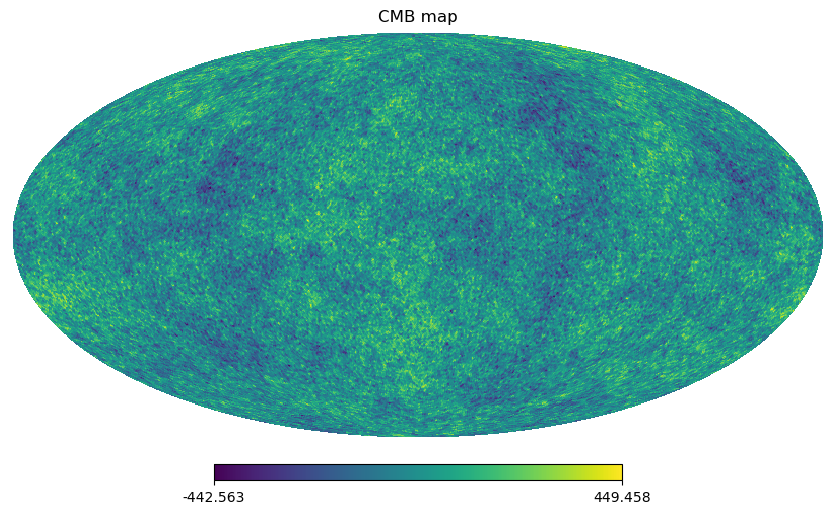

In [5]:
cmb_maps = InputMaps({'cmb':42}, [150e9], 1, params['nside']).m_nu[0]
print(cmb_maps.shape)
hp.mollview(cmb_maps[:, 0], title='CMB map')

196608


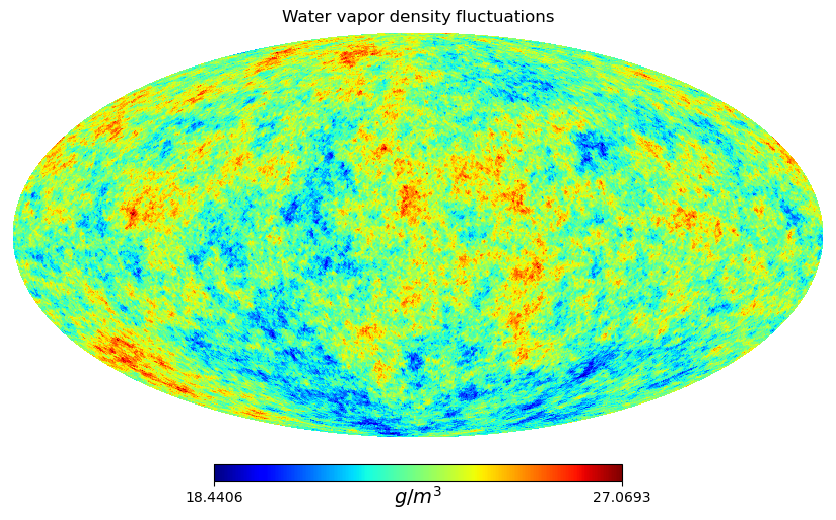

In [6]:
wv_fluctuations = atm.rho_map
print(wv_fluctuations.shape[0])
hp.mollview(wv_fluctuations, cmap='jet', title='Water vapor density fluctuations', unit=r'$g/m^{3}$')

In [7]:
atm.frequencies

array([132.92014967, 136.30295415, 139.77185066, 143.32903024,
       146.97673968, 150.71728296, 154.5530227 , 158.48638163,
       162.51984414, 166.65595787, 194.94955285, 199.91099941,
       204.9987143 , 210.21591101, 215.56588487, 221.05201501,
       226.67776663, 232.44669305, 238.36243807, 244.42873822])

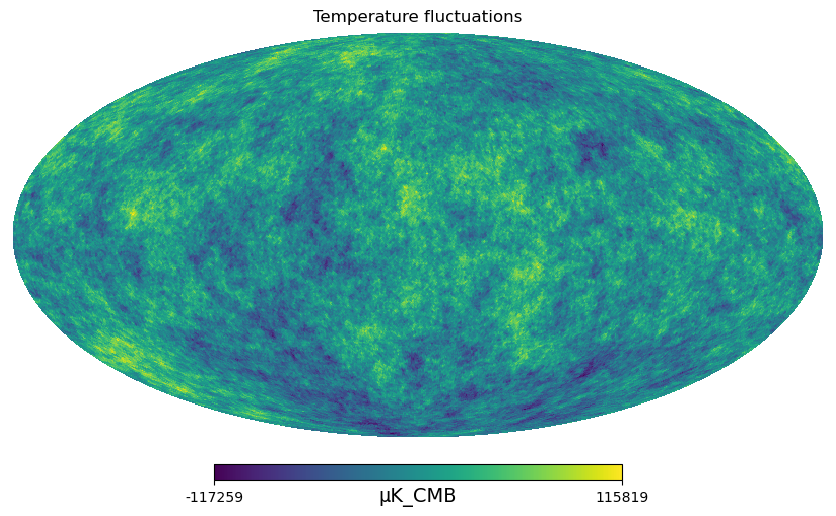

In [8]:
temp_fluctuations = np.zeros((wv_fluctuations.shape[0], 3))
temp_fluctuations[:, 0] = atm.get_temp_maps(wv_fluctuations)[0]
temp_fluctuations[:, 0] -= np.mean(temp_fluctuations[:, 0])

hp.mollview(temp_fluctuations[:, 0], title='Temperature fluctuations', unit='µK_CMB')

In [9]:
q_instrument = QubicInstrument(qubic_dict)
q_sampling = get_pointing(qubic_dict)
q_scene = QubicScene(qubic_dict)

q_acquisition = QubicAcquisition(q_instrument, q_sampling, q_scene, qubic_dict)

You asked 2000 pointings with repeat strategy so I will provide 666 pointings repeated 3 times.


In [10]:
coverage = q_acquisition.get_coverage()

covnorm = coverage / coverage.max()
seenpix = covnorm > params['coverage_cut']

center = np.array([0, -57])
qubic_patch = qubic.lib.Qsamplings.equ2gal(center[0], center[1])

Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.


In [11]:
H_qubic = q_acquisition.get_operator()
R_qubic = ReshapeOperator(H_qubic.shapeout, H_qubic.shape[0])
invN_qubic = R_qubic(q_acquisition.get_invntt_operator(False, False)(R_qubic.T))
d_qubic = H_qubic(temp_fluctuations).ravel()

Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.


In [12]:
print(temp_fluctuations.shape)
print(cmb_maps.shape)

(196608, 3)
(196608, 3)


In [13]:
H_planck = ReshapeOperator(temp_fluctuations.shape, temp_fluctuations.ravel().shape)
invN_planck = DiagonalOperator(np.ones(H_planck.shapeout))
d_planck = H_planck(temp_fluctuations)

In [14]:
if params['external_data']:
    H = BlockColumnOperator([R_qubic(H_qubic), H_planck], axisout=0)
    invN = BlockDiagonalOperator([invN_qubic, invN_planck], axisout=0)
    d = np.concatenate((d_qubic, d_planck))
else:
    H = R_qubic(H_qubic)
    invN = invN_qubic
    d = d_qubic

In [15]:
A = H.T * invN * H
b = H.T * invN * d.flatten()
x0 = temp_fluctuations*0
true_maps = temp_fluctuations #+ cmb_maps

In [ ]:
stacked_dptdp_inv = np.zeros((len(H.operands),12*params['nside']**2))
for i in range(len(H.operands)):
    H_single = H
    D = H_single.operands[2]
    P = H_single.operands[-1]
    sh = P.matrix.data.index.shape
    no_det = 992
    
    point_per_det = int(sh[0] / no_det)
    mapPtP_perdet_seq = np.zeros((no_det,12*params['nside']**2))
    for det in range(no_det):
        mapPitPi = np.zeros(12*params['nside']**2)
        for peak in range(sh[1]):
            for sample in range(det*point_per_det, (det+1)*point_per_det):
                mapPitPi[P.matrix.data.index[sample,peak]] += P.matrix.data.r11[sample,peak]**2
        mapPtP_perdet_seq[det,:] = mapPitPi

    D_elements = D.data
    D_sq = D_elements**2
    mapPtP_seq_scaled = D_sq[:, np.newaxis] * mapPtP_perdet_seq 
    dptdp = mapPtP_seq_scaled.sum(axis = 0)
    dptdp_inv = 1 / dptdp
    dptdp_inv[np.isinf(dptdp_inv)] = 0.
    stacked_dptdp_inv[i] = dptdp_inv
M = BlockDiagonalOperator( \
            [DiagonalOperator(ci, broadcast='rightward') for ci in stacked_dptdp_inv],
            new_axisin=0)
#preconditioner = DiagonalOperator(cov_inv, broadcast='rightward') za monoacquisition

In [ ]:
# Run PCG
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-15,
    maxiter=200,
    disp=True,
    M=M.operands[0],
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

2
 Iter     Tol      time
   1: 1.8669e-01 0.13400 [ 8026.23547568 12965.15519661 17520.79241462 ... 12749.43357241
 11295.77861697   940.52724366]
2
   2: 7.3543e-02 0.12665 [1163.99698136 4173.97733922 7352.89077388 ... 5930.24148088 5286.86774987
  303.82046195]
2
   3: 4.8393e-02 0.11586 [2725.00715611 4547.7203492  6732.97358309 ... 1353.01730473  929.58732722
 2539.49549797]
2
   4: 1.6942e-02 0.13454 [1050.26445675 1494.57569238 2438.77631313 ...  224.25750297   26.82430097
  755.15019156]
2
   5: 1.2912e-02 0.12283 [1920.86052514 1740.87393457 2436.95881284 ...  651.96284973  273.2874732
  155.04951203]
2
   6: 7.8621e-03 0.13819 [1433.55405816  872.46699868 1477.32585563 ...   60.80203858  473.38608605
  993.37919805]
2
   7: 8.0305e-03 0.14082 [1401.84603524 1121.36622535 1492.26895713 ...  210.69314746  316.55197635
 1155.77844137]
2
   8: 6.7813e-03 0.13903 [1347.51435222 1190.07205949 1294.11747089 ...  396.08244286   57.97985839
  981.32818924]
2
   9: 4.6088e-03 0.13357 

Text(0, 0.5, 'Convergence')

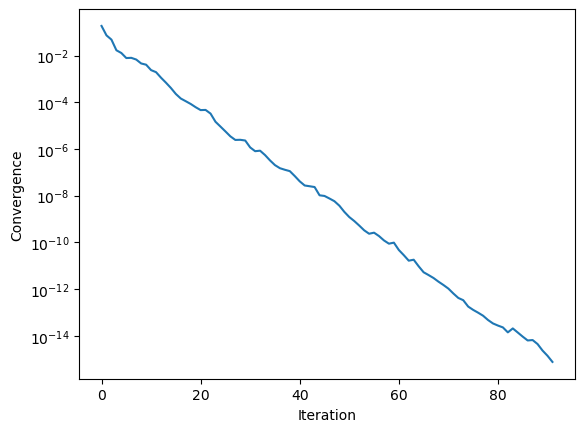

In [ ]:
plt.plot(output['convergence'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

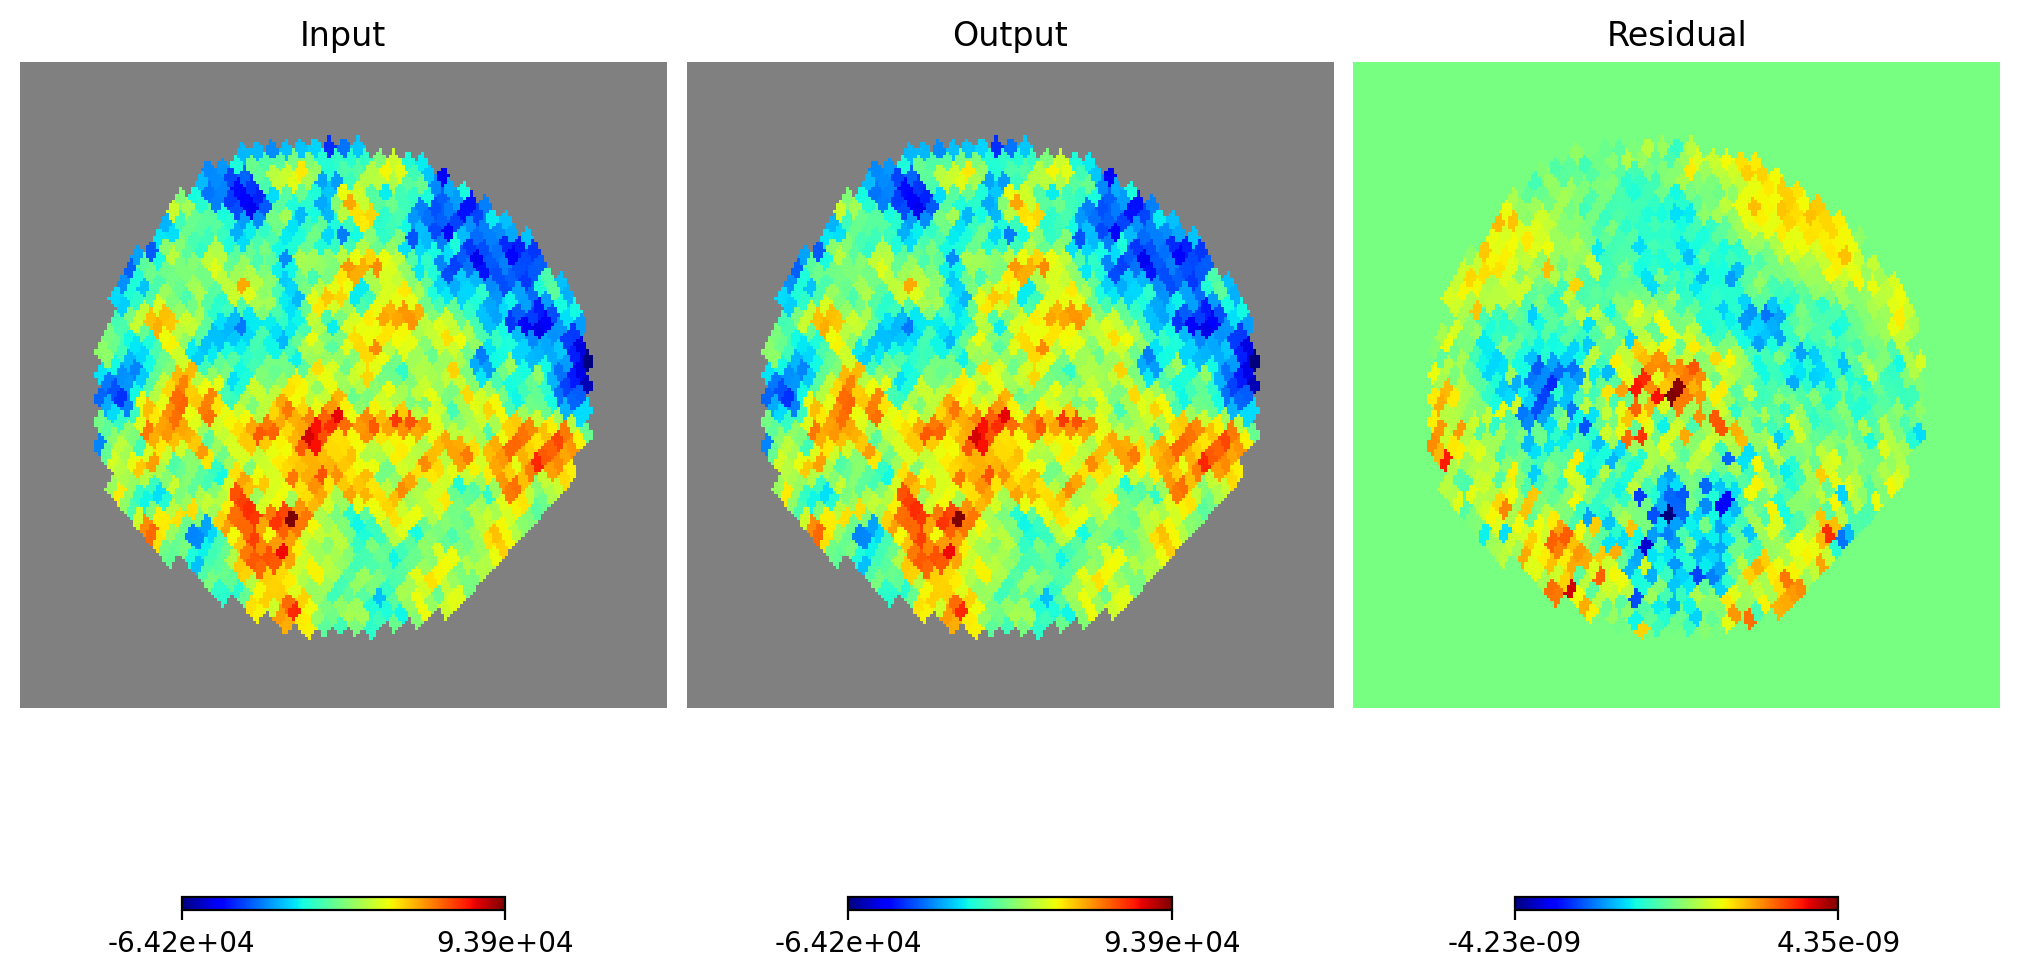

In [ ]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

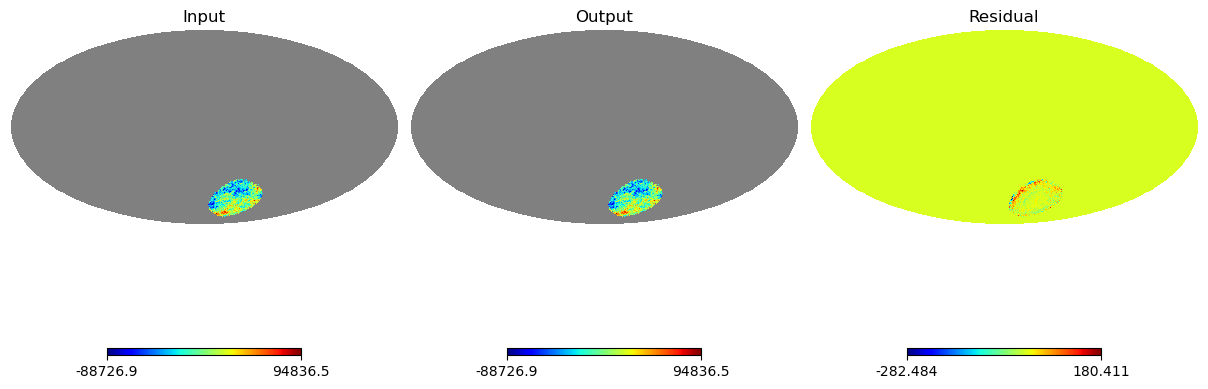

In [ ]:
plt.figure(figsize=(12, 25))
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.mollview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k), title='Input', notext=True)
hp.mollview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k+1), title='Output', notext=True)
hp.mollview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

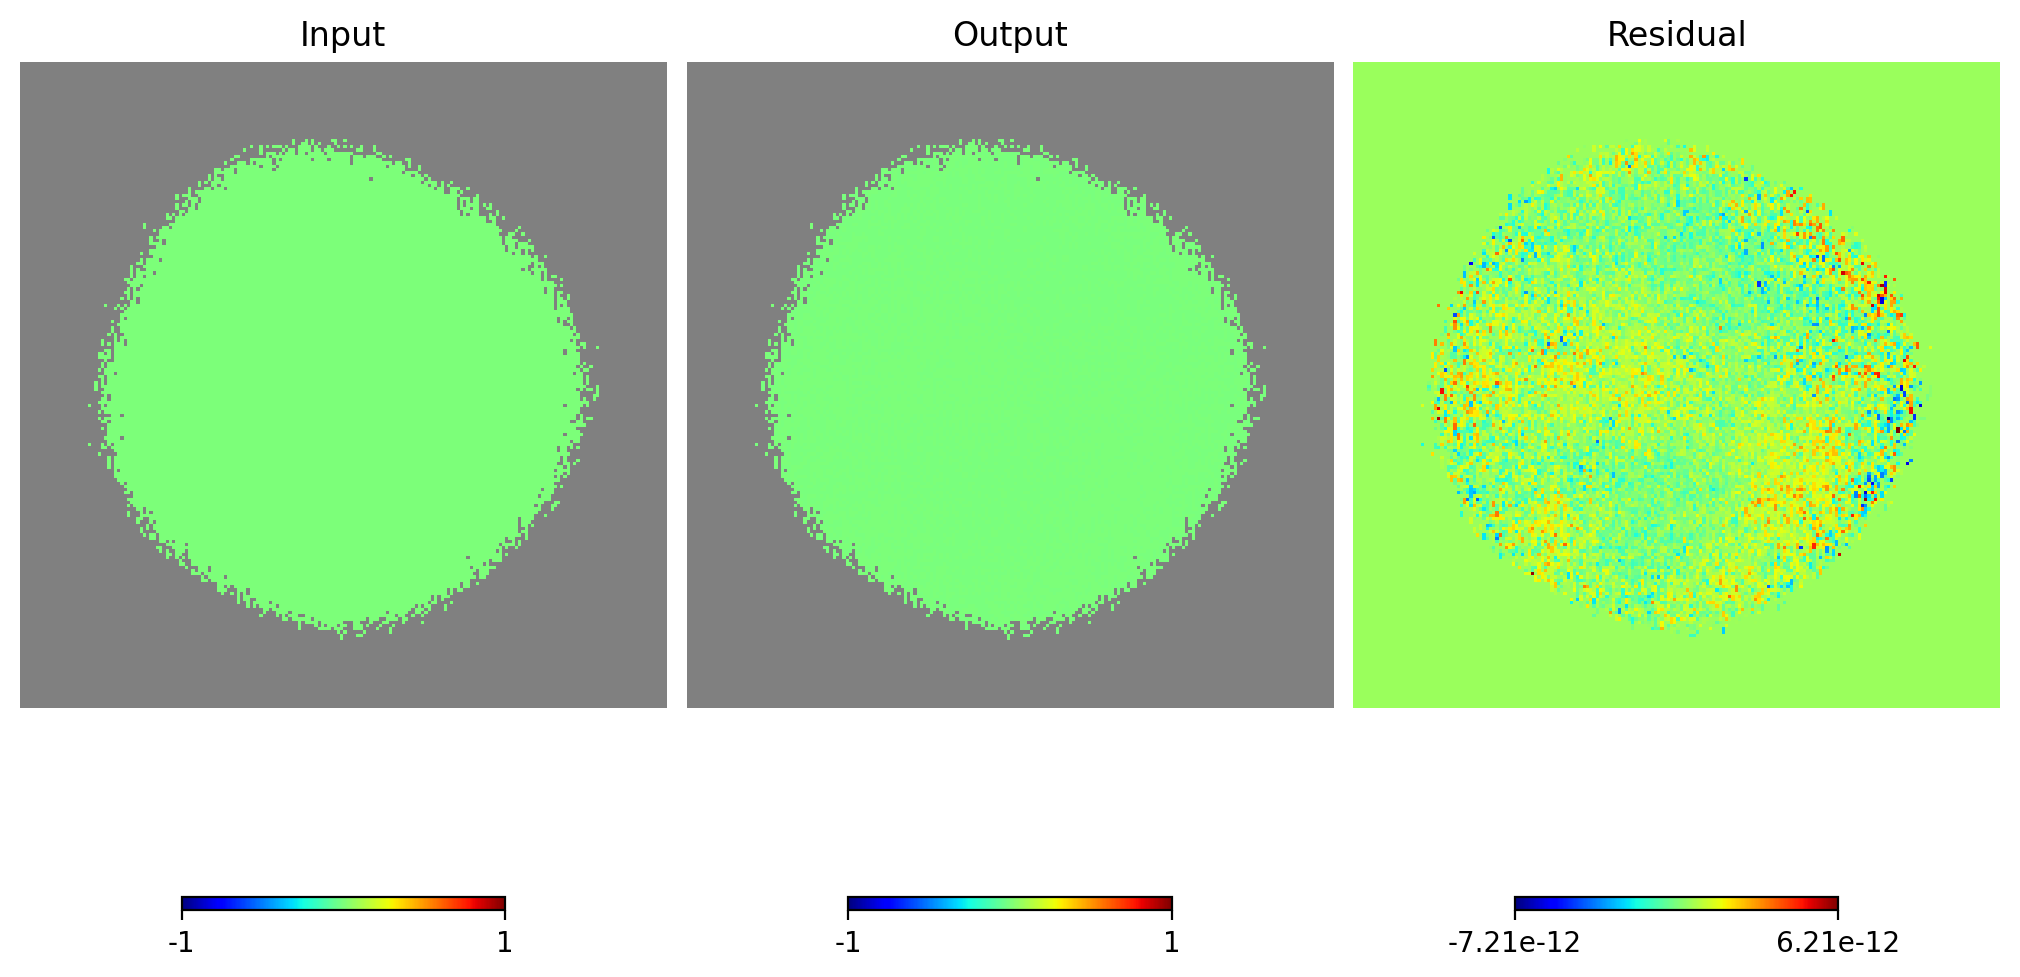

In [ ]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 1
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

In [ ]:
npix = hp.nside2npix(128)
test = np.ones(npix)
cl = hp.anafast(test)

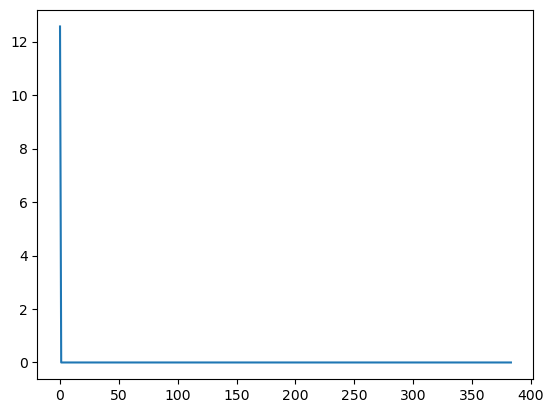

In [ ]:
plt.plot(cl)

In [ ]:
cl = np.zeros(100)
cl[10] = 1
cl[20] = 1
maps = hp.synfast(cl, 256)

In [ ]:
maps.shape

(786432,)

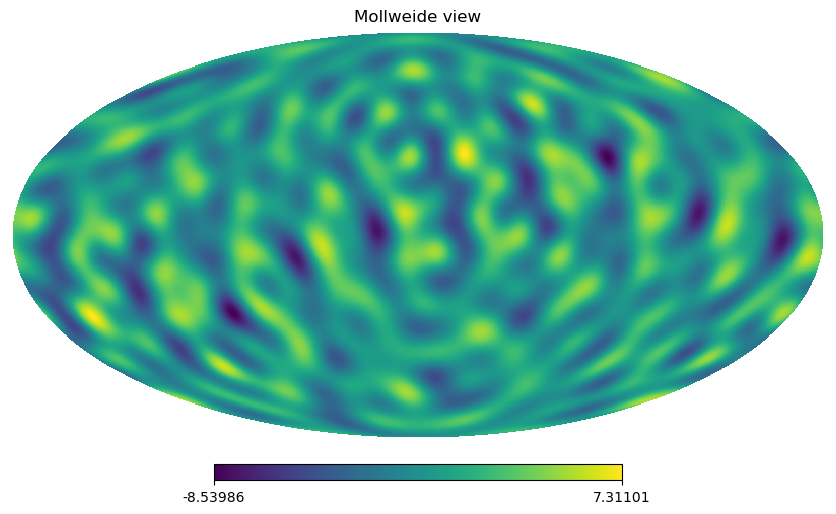

In [ ]:
hp.mollview(maps)

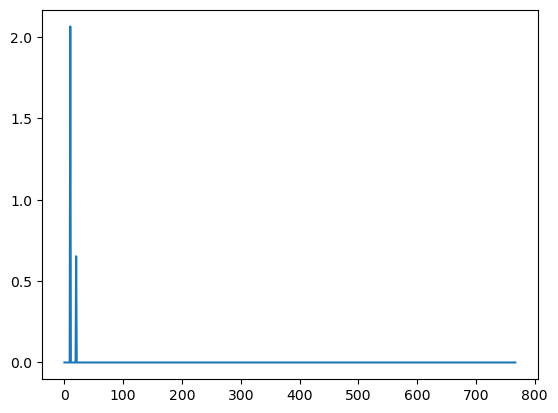

In [ ]:
plt.plot(hp.anafast(maps))